### Reinforcement learning the active learning policy 



In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al
import src.viz as viz

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.distributions import Categorical
# import pyro

%matplotlib inline

### Get the data:

Get MNIST formatted from PyTorch.

In [3]:
# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set),shuffle=False)

In [4]:
# Get x/y split for the test set 
train_x, train_y, val_x, val_y = al.get_dataset_split(train_set)
test_x,test_y = al.get_xy_split(test_loader)

### Make the models:

Below we make both the logistic regression and the CNN for experiemnts with RL on active learning policies

In [5]:
# Define the logistic regression model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return F.log_softmax(x.view(-1,self.classes),dim=1)

# Define the CNN model 
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
    

In [6]:
al = imp.reload(al)
viz = imp.reload(viz)
########### GLOBAL EXPERIMENT PARAMS ############
# Epochs of adding additional points
meta_epochs = 5
# Epochs per training run
ept = 5
# Number of points to start with and add each run 
npoints = 20
batch_size = 10
learning_rate = 0.01
# Number of runs to create a sampling distribution to quantify error 
samp_runs = 2

def try_policy(policy, meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs):
    # general policy test 
    try_acc = []
    for i in tqdm(range(samp_runs)):
        model_try = logreg(classes=10)
#         model_try = CNN()
        loss_try = nn.NLLLoss()
        optimizer_try = optim.SGD(model_try.parameters(), lr=learning_rate)
        experi = al.ExperiAL(model_try, train_x, train_y, val_x, val_y, loss_try, optimizer_try)
        experi.set_params(meta_epochs=5)
        _, val_acc = experi.active_learn(policy=policy)
        try_acc.append(val_acc)
    print(f'Active Learning with {policy} policy done!')
    return try_acc

# random_acc = try_policy('random', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
# boundary_acc = try_policy('boundary', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
# model = logreg(classes=10)
# loss_func = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=.01)
# experiment = al.ExperiAL(model, train_x, train_y, val_x, val_y, loss_func, optimizer)
# experiment.active_learn(policy='boundary', meta_epochs=5, epochs_per_train=5, npoints=20, batch_size=10)

# accs = [random_acc,boundary_acc,entropy_acc, confidence_acc,uniform_acc]
# sample_acc = [a[-1][-1] for a in accs]
# labs = ['Random','Boundary','Max Entropy', 'Least Confidence','Uniform']
# nice_labs = [lab+f' {a}' for lab,a in zip(labs,sample_acc)]
# viz.plot_results(meta_epochs,accs,nice_labs)

In [1]:
class Environment(object):
    def __init__(self, model, train_x, train_y, val_x, val_y, loss_func, optimizer):
        self.use_cuda = torch.cuda.is_available()
        self.model = model.cuda() if self.use_cuda else model
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.loss_func = loss_func
        self.optimizer = optimizer
        
        
    def get_req_points(self, unlab_x, unlab_y, policy, n, random_seed=13):
        """ This function gets the number of points requested based on the function
        "policy" that is passed. "policy" can be any function to test.
        ---------
        Args: model; any function that produces a valid array of length unlab_loader, but
                normally a torch model.
              unlab_loader; a torch DataLoader or other datatype of not using torch functionality
              policy; a passed fucntion that decides which points are most important for labeling
              num_points; int, the number of points indices we will return asking for labels.
        ---------
        Returns: array of length "num_points" that represent the indices of the points
                    to be labeled.
        """
        if policy!='random':
            pred_y = self.model(Variable(unlab_x.cuda())) if self.use_cuda else self.model(Variable(unlab_x))
            if policy=='boundary':
                fn = al.boundary_policy
            elif policy=='uniform':
                fn = al.uniform_policy
            elif policy=='max_entropy':
                fn = al.max_entropy_policy
            elif policy=='conf':
                fn = al.least_confidence_policy
            idxs = fn(pred_y, n=n, use_cuda=self.use_cuda)
            new_u_x, new_u_y, add_x, add_y = al.get_idx_split(unlab_x, unlab_y, idxs)
        else:
            new_u_x, new_u_y, add_x, add_y = al.get_dataset_split((unlab_x,unlab_y), other_size=n, random_seed=random_seed)
        return new_u_x, new_u_y, add_x, add_y

### RL approach - Policy Gradients (PG)

* Source: http://karpathy.github.io/2016/05/31/rl/

Here I will try the PG appraoch to this problem.

##### Ideas:

* actions are choosing the policy by which we choose the next point. 

* so is the state the performance of the model or the model itself or the parameters?? 

* OR IS THE STATE THE SET OF UNLABELED POINTS?!?!

* State is the set of all training points 

* NO state should be the marginals $p(\mathbf{y}|x_i)$ for real!!!

* could use grad of accuracy to approx reward function. steeper the gradient higher the reward.

In [55]:
# Make the RL agent to interact with the environment 
class AgentRL(nn.Module):
    def __init__(self, inpt_dim, hidden_dim, num_policies):
        super(AgentRL, self).__init__()
        self.num_policies = num_policies
        self.inner_layer = nn.Linear(inpt_dim, hidden_dim)
        self.outer_layer = nn.Linear(hidden_dim, num_policies)
        self.rewards = []
        self.saved_log_probs = []
        
    def forward(self, x):
        x = x.view(1,-1)
        x = F.relu(self.inner_layer(x))
        x = self.outer_layer(x)
        return F.softmax(x, dim=1)

# The incoming state is the marginals on all the points 
def select_action(agent, state, use_cuda=False):
    """ Get the probabilities for different actions and sample to select one. """
    probs = agent(state)
    m = Categorical(probs)
    action = m.sample()
    agent.saved_log_probs.append(m.log_prob(action))
    return action.data[0]

def finish_experiment(agent, optimizer, gamma=0.99, use_cuda=False):
    """ after the training episode is done, we can finally backprop over the expectation of the rewards. """
    rewards = get_rewards(agent, gamma=gamma, use_cuda=use_cuda)
    
    #TODO: List comp when optimizing
    policy_loss = []
    for log_prob, reward in zip(agent.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)
        
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    
    del agent.rewards[:]
    del agent.saved_log_probs[:]

def get_rewards(agent, gamma=0.99, use_cuda=False):
    """ Get the discounted rewards from the episode of training. """
    rewards, R = [], 0
    for r in agent.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards).cuda() if use_cuda else torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    return rewards

def run_experiments(agent, optimizer_agent, n_experiments, epochs_per_train=5, npoints=10, \
                    batch_size=10, meta_epochs=10, use_cuda=False):
    running_reward = 1.0
    policy_key = {0: 'random', 1: 'boundary', 2: 'max_entropy', 3: 'conf', 4: 'uniform'}
    policies_chosen, rewards_total = [],[]
    for i_exp in tqdm(range(n_experiments)):
        ### Reset the envorinment 
        model_try = logreg(classes=10)
        loss_try = nn.NLLLoss()
        optimizer_try = optim.Adam(model_try.parameters(), lr=0.01)
        train_tensor = train_x.cuda() if use_cuda else train_x
        experiment = al.ExperiAL(model_try, train_x, train_y, val_x, val_y, loss_try, optimizer_try)
        experiment.set_params(meta_epochs=1, npoints=npoints, batch_size=batch_size, epochs_per_train=epochs_per_train)
        
        # Calculate the initial state 
        state = model_try(Variable(train_tensor))
        
        # Run the experiment up to training on 1000 points 
        policies,track_reward = [],[]
#         for t in range(3):  # Don't infinite loop while learning
        for t in range(meta_epochs):
            action = select_action(agent, state, use_cuda=use_cuda)
            policies.append(policy_key[action])
            _, reward = experiment.active_learn(policy=policy_key[action])
            track_reward.append(reward)
            state = model_try(Variable(train_tensor))
            agent.rewards.append(reward[0])
            
        policies_chosen.append(policies)
        rewards_total.append(np.array(track_reward))
        running_reward = running_reward * 0.99 + t * 0.01
        finish_experiment(agent, optimizer_agent, gamma=0.99, use_cuda=use_cuda)
        if i_exp % 10 == 0:
            print('Experiment {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_exp, t, running_reward))
    return policies_chosen, np.array(rewards_total)

arl = AgentRL(int(len(train_x)*10), 128, 5)
optimizer_rl = optim.Adam(arl.parameters(), lr=1e-2)

pc,ac = run_experiments(arl, optimizer_rl, n_experiments=500, epochs_per_train=5, npoints=20, meta_epochs=25, batch_size=10)

A Jupyter Widget

Experiment 0	Last length:    24	Average length: 1.23
Experiment 10	Last length:    24	Average length: 3.41
Experiment 20	Last length:    24	Average length: 5.38
Experiment 30	Last length:    24	Average length: 7.16
Experiment 40	Last length:    24	Average length: 8.77
Experiment 50	Last length:    24	Average length: 10.22
Experiment 60	Last length:    24	Average length: 11.54
Experiment 70	Last length:    24	Average length: 12.73
Experiment 80	Last length:    24	Average length: 13.81
Experiment 90	Last length:    24	Average length: 14.78
Experiment 100	Last length:    24	Average length: 15.67
Experiment 110	Last length:    24	Average length: 16.46
Experiment 120	Last length:    24	Average length: 17.18
Experiment 130	Last length:    24	Average length: 17.83
Experiment 140	Last length:    24	Average length: 18.42
Experiment 150	Last length:    24	Average length: 18.96
Experiment 160	Last length:    24	Average length: 19.44
Experiment 170	Last length:    24	Average length: 19.88
Experime

### Idea:

maybe try a simulated annealing type $e^{\frac{x}{T}}$ to make the slight differences in the rewards more pronounced

['uniform', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary', 'boundary']
[ 0.86]


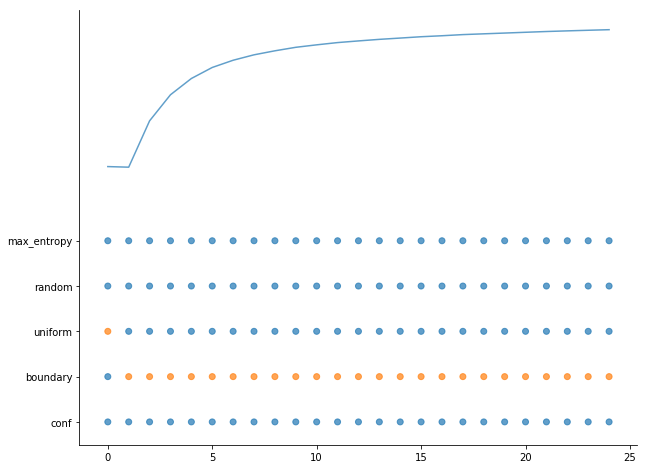

In [70]:

def viz_rl(pc,ac,idx,alp=0.7):
    accs = ac.mean(axis=0)
    me = len(pc[idx])
    cmap= plt.get_cmap('tab10')
    labels= ['conf','boundary','uniform','random','max_entropy']
    plt.figure(figsize=(10,8))
    plt.scatter(range(me),[10]*me,c=[cmap(1) if i=='conf' else cmap(0) for i in pc[idx]],alpha=alp)
    plt.scatter(range(me),[10.1]*me,c=[cmap(1) if i=='boundary' else cmap(0) for i in pc[idx]],alpha=alp)
    plt.scatter(range(me),[10.2]*me,c=[cmap(1) if i=='uniform' else cmap(0) for i in pc[idx]],alpha=alp)
    plt.scatter(range(me),[10.3]*me,c=[cmap(1) if i=='random' else cmap(0) for i in pc[idx]],alpha=alp)
    plt.scatter(range(me),[10.4]*me,c=[cmap(1) if i=='max_entropy' else cmap(0) for i in pc[idx]],alpha=alp)
    plt.yticks([10,10.1,10.2,10.3,10.4], labels, rotation='horizontal')
    plt.plot(range(me),accs+10,alpha=alp)
    sns.despine()

ii = 499
viz_rl(pc,ac,ii)
print(pc[ii])
print(ac[ii][-1])

In [14]:
mod = logreg(classes=10)
arl = AgentRL(int(len(train_x)*10), 128, 5)
optimizer = optim.Adam(arl.parameters(), lr=1e-2)
state = mod(Variable(train_x))
result = arl(state)
result

torch.Size([1, 500000])


Variable containing:
 0.1896  0.2148  0.1515  0.3086  0.1356
[torch.FloatTensor of size 1x5]

### One RL approach (DQN):

This is currently not working but could be good to try after policy gradients 

1 epoch acc 0.8274
OrderedDict([('w.weight', 
-3.0095e-02 -4.3774e-03 -1.1128e-02  ...  -1.8133e-02  1.5993e-02 -6.1285e-03
-1.1412e-03  1.1096e-02 -3.4081e-02  ...  -1.3653e-02 -2.1021e-02  6.1761e-03
-2.7035e-02  3.1876e-02  2.7182e-02  ...  -2.4003e-02 -3.5375e-02  3.4048e-02
                ...                   ⋱                   ...                
 2.9983e-03  1.9402e-03  2.5775e-02  ...   2.1912e-02 -3.3439e-02  1.1415e-02
-2.7456e-02 -3.3077e-04 -2.6443e-02  ...  -2.8893e-02  2.0001e-02  9.3709e-03
-9.9710e-03  1.2108e-02 -3.2164e-02  ...   2.9064e-02 -1.2496e-02 -1.7155e-02
[torch.FloatTensor of size 10x784]
), ('w.bias', 
1.00000e-02 *
 -6.5094
  9.2180
 -3.3772
  0.2998
  1.2790
  4.2864
  0.2122
  4.4110
 -4.8635
 -2.7203
[torch.FloatTensor of size 10]
)])
OrderedDict([('w.weight', 
-0.0301 -0.0044 -0.0111  ...  -0.0181  0.0160 -0.0061
-0.0011  0.0111 -0.0341  ...  -0.0137 -0.0210  0.0062
-0.0270  0.0319  0.0272  ...  -0.0240 -0.0354  0.0340
          ...             ⋱   

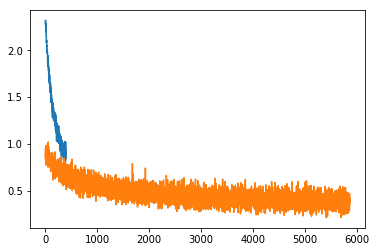

In [9]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

model = logreg(classes=10)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)
experiment = al.ExperiAL(model, train_x, train_y, val_x, val_y, loss_func, optimizer)
it,ac = experiment._train(train_x, train_y, epochs=1, batch_size=128)

plt.plot(it,ac)
sd = model.state_dict()
print('1 epoch acc',al.accuracy(model,val_x,val_y))
print(sd)
it,ac = experiment._train(train_x, train_y, epochs=15, batch_size=128)
plt.plot(it,ac)
sd2 = model.state_dict()
print(sd2)
print('20 epoch acc',al.accuracy(model,val_x,val_y))
print(sd)
model.load_state_dict(sd)
model.state_dict()
print('should be 5 epoch acc',al.accuracy(model,val_x,val_y))


In [11]:
preds = [5,5,6,7,8,4,3,2]
num_points, sampler = len(preds), np.array(range(len(preds)))
# output = []
for i in range(num_points):
    print(np.random.choice(preds, size=num_points, replace=False))

[2 8 6 5 5 3 4 7]
[2 3 5 4 7 6 8 5]
[5 8 5 2 7 6 4 3]
[4 5 2 6 7 8 3 5]
[5 6 2 5 4 8 3 7]
[6 5 4 2 5 7 3 8]
[8 5 2 4 7 3 5 6]
[5 3 5 7 4 8 2 6]
